# Detecting Faces

## Imports

In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import log_loss

from collections import Counter
from PIL import Image

from tqdm import tqdm

In [2]:
%%capture

!python imbalanced-dataset-sampler-master/setup.py install
!pip install imbalanced-dataset-sampler-master/.

## Data Visualisation & Structuring

### Data Loader

In [3]:
# Transfer data to tensor vectors and training/ testing datasets
train_dir = './start_deep/train_images'
test_dir = './start_deep/test_images'

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2
batch_size = 32

num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

train_sampler = ImbalancedDatasetSampler(train_data, train_new_idx)
valid_sampler = ImbalancedDatasetSampler(train_data, valid_idx)

#train_sampler = SubsetRandomSampler(train_new_idx)
#valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)
classes = ('noface','face')

print("Train dataset length \t:",len(train_data))
print ("Test dataset length \t:", len(test_data))

Train dataset length 	: 91720
Test dataset length 	: 7628


### In depth look at our data

#### Face and NoFace ratio in datasets

[Text(0, 0, 'noface'), Text(1, 0, 'face')]

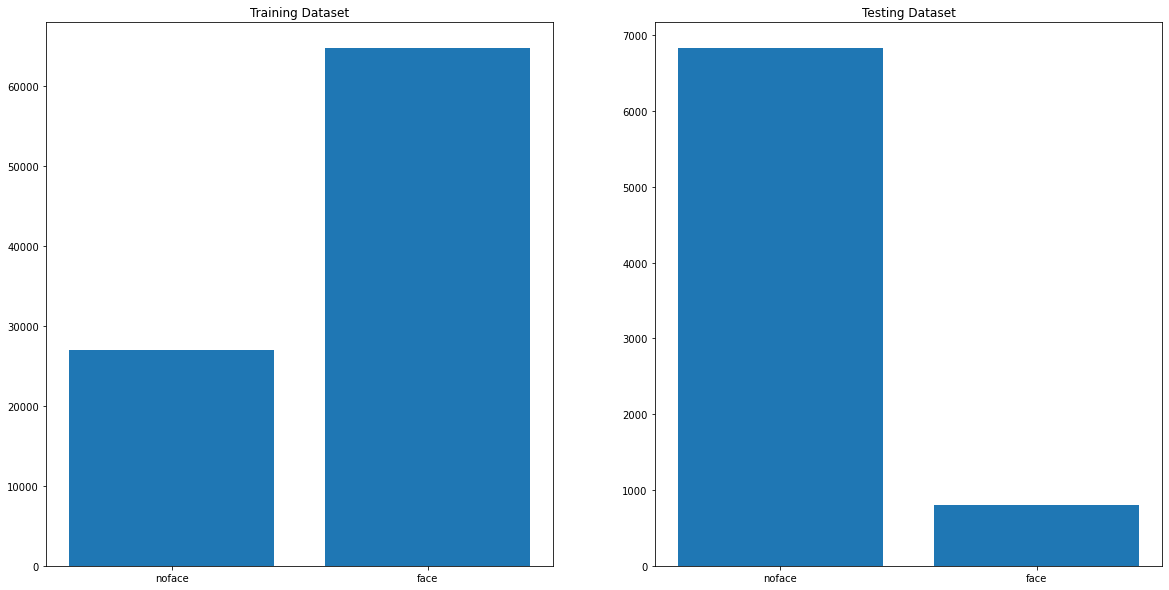

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax0, ax1 = ax.flatten()

ax0.set_title("Training Dataset")
ax0.bar(*zip(*dict(Counter(train_data.targets)).items()))
ax0.set_xticks([0, 1])
ax0.set_xticklabels(["noface", "face"])

ax1.set_title("Testing Dataset")
ax1.bar(*zip(*dict(Counter(test_data.targets)).items()))
ax1.set_xticks([0, 1])
ax1.set_xticklabels(["noface", "face"])

#### Ratio in train data loader

In [5]:
count_train_face = 0
count_train_no_face = 0

for data, target in train_loader:
    s = np.array(target).sum()
    count_train_face += s
    count_train_no_face += batch_size - s

print("Face \t:", count_train_face)
print ("NoFace \t:", count_train_no_face)

Face 	: 36620
NoFace 	: 36756


#### Ratio in validation data loader

In [6]:
count_valid_face = 0
count_valid_no_face = 0

for data, target in valid_loader:
    s = np.array(target).sum()
    count_valid_face +=s
    count_valid_no_face += batch_size - s

print("Face \t:", count_valid_face)
print ("NoFace \t:", count_valid_no_face)

Face 	: 9081
NoFace 	: 9287


#### Ratio in test data loader

In [7]:
count_test_face = 0
count_test_no_face = 0

for data, target in test_loader:
    s = np.array(target).sum()
    count_test_face += s
    count_test_no_face += batch_size - s

print("Face \t:", count_test_face)
print ("NoFace \t:", count_test_no_face)

Face 	: 797
NoFace 	: 6851


#### Example of a face image

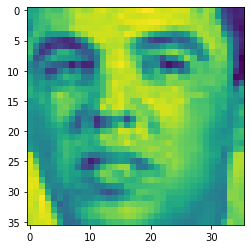

In [8]:
img = Image.open('./start_deep/train_images/1/Image000605.pgm')
plt.imshow(img)

#### Example of a noface image

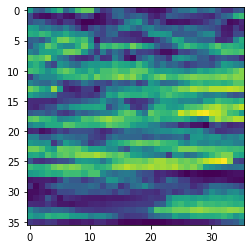

In [9]:
img = Image.open('./start_deep/train_images/0/137021_1_42_76_76.pgm')
plt.imshow(img)

## Building Our Model

### Helpers

#### error Function

In [10]:
# Description: error function to evaluate distance between prediction and label 
# Input : output (of model), labels
# Output: average error
def error(output, labels):
    correct = 0
    predicted = torch.max(output.data, 1)[1] 
    correct += (predicted == labels).sum()
    return 1 - correct.item()/len(output.data)

#### show_image Function

In [11]:
def show_image(images):
    image = torchvision.utils.make_grid(images, nrow=15)
    image = image / 2 + 0.5
    npimg = image.numpy()
    
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

#### ConfusionMatrixMeter Class

In [12]:
# Input : output (of model), labels
# Output: average error
class ConfusionMatrixMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.true_pos = 0
        self.true_neg = 0
        self.false_pos = 0
        self.false_neg = 0

    def update(self, output, target):
        for i in range(len(output)):
            # predicted negative (no face)
            if output[i][0]>output[i][1]: 
                if target[i]==0:
                    self.true_neg +=1
                else:
                    self.false_neg +=1
                    
            # predicted positive (face)
            else:                         
                if target[i]==1:
                    self.true_pos +=1
                else:
                    self.false_pos +=1

#### AverageMeter Class

In [13]:
# Description: class used to keep count of the average error and loss during training
# Input : 
# Output:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Neural Network

####  Architecture 1

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(9 * 9 * 64, 100)
        self.fc2 = nn.Linear(100, 2)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self, X): # batch of n images
        #print ("input",X.size())
        out = self.layer1(X)
        #print ("after layer1",out.size())
        out = self.layer2(out)
        #print ("after layer2",out.size())
        out = out.reshape(out.size(0), -1)
        #print ("after reshape",out.size())
        out = self.drop_out(out)
        #print ("after drop",out.size())
        out = self.fc1(out)
        #print ("after fc1",out.size())
        out = self.fc2(out)
        #print ("after fc2",out.size())
        #out = F.log_softmax(out, dim=1)
        #print ("after log softmax",out.size())
        return out 

### Hyperparameters

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 10
lr = 0.01
cv_folds = 1

n_train_batches = len(train_loader)
n_valid_batches = len(valid_loader)
n_test_batches = len(test_loader)

### Training Neural Network

Epoch 1 - Validating 	: 100%|██████████| 574/574 [00:22<00:00, 25.18it/s]


train_loss: 0.24075 	 train_err: 8.98%
valid_loss: 0.14065 	 valid_err: 5.02%


Epoch 2 - Validating 	: 100%|██████████| 574/574 [00:21<00:00, 26.83it/s]


train_loss: 0.18419 	 train_err: 6.50%
valid_loss: 0.11079 	 valid_err: 3.65%


Epoch 3 - Validating 	: 100%|██████████| 574/574 [00:19<00:00, 29.71it/s]


train_loss: 0.18775 	 train_err: 6.52%
valid_loss: 0.10300 	 valid_err: 3.28%


Epoch 4 - Validating 	: 100%|██████████| 574/574 [00:19<00:00, 29.77it/s]


train_loss: 0.18536 	 train_err: 6.41%
valid_loss: 0.10867 	 valid_err: 3.78%


Epoch 5 - Validating 	: 100%|██████████| 574/574 [00:20<00:00, 27.63it/s]


train_loss: 0.18548 	 train_err: 6.31%
valid_loss: 0.06898 	 valid_err: 2.13%


Epoch 6 - Validating 	: 100%|██████████| 574/574 [00:20<00:00, 27.62it/s]


train_loss: 0.19134 	 train_err: 6.39%
valid_loss: 0.10470 	 valid_err: 2.99%


Epoch 7 - Validating 	: 100%|██████████| 574/574 [00:19<00:00, 29.83it/s]


train_loss: 0.18411 	 train_err: 6.11%
valid_loss: 0.10289 	 valid_err: 3.23%


Epoch 8 - Validating 	: 100%|██████████| 574/574 [00:19<00:00, 29.47it/s]


train_loss: 0.17840 	 train_err: 6.02%
valid_loss: 0.10606 	 valid_err: 3.75%


Epoch 9 - Validating 	: 100%|██████████| 574/574 [00:21<00:00, 27.33it/s]


train_loss: 0.18476 	 train_err: 6.15%
valid_loss: 0.08580 	 valid_err: 2.70%


Epoch 10 - Validating 	: 100%|██████████| 574/574 [00:22<00:00, 25.56it/s]


train_loss: 0.20460 	 train_err: 7.07%
valid_loss: 0.11876 	 valid_err: 3.27%


Testing : 100%|██████████| 239/239 [00:09<00:00, 25.42it/s]


test_loss: 0.42592 	 test_acc: 8.23%


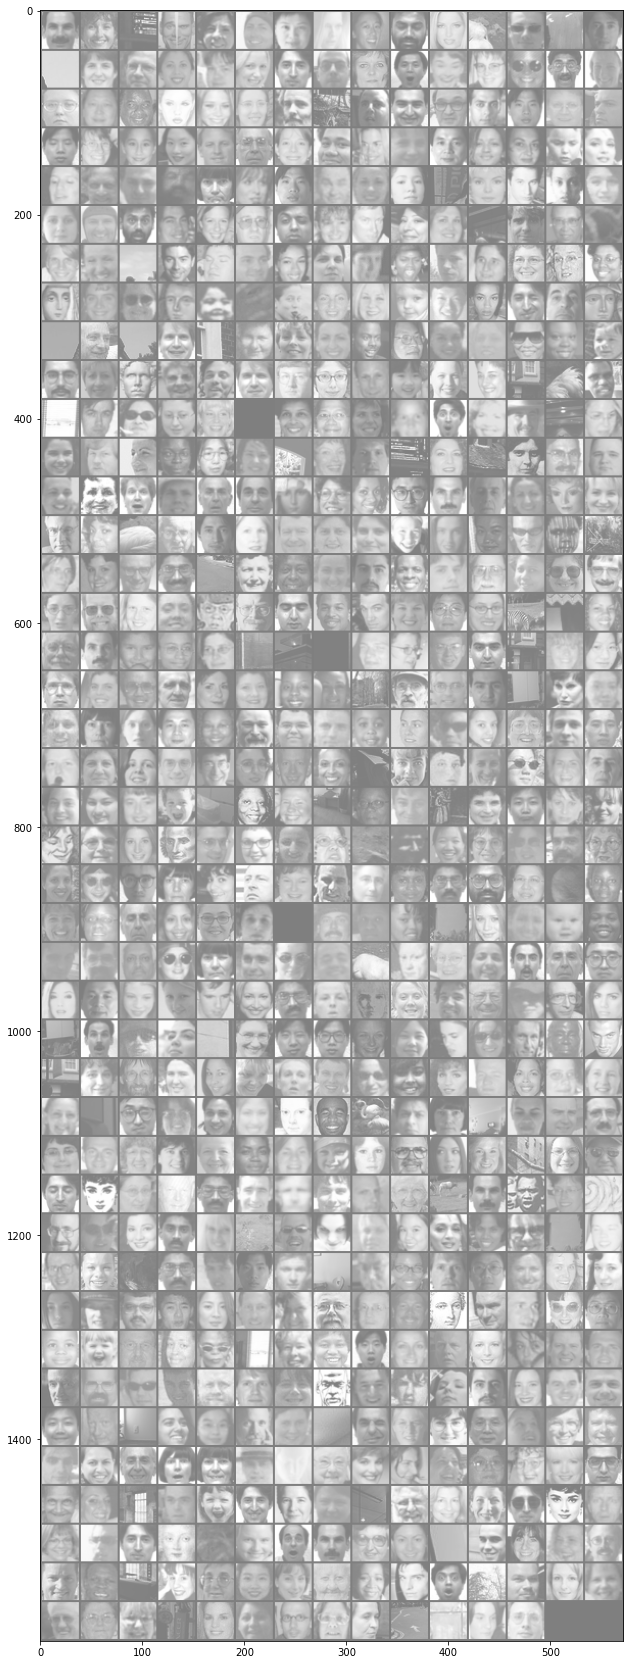

In [18]:
model = None
criterion = nn.CrossEntropyLoss()

# Train and test functions
def train(X, y):
    optimizer.zero_grad()
    output = model(X)
    loss_train = criterion(output, y)
    loss_train.backward()
    optimizer.step()
    return output, loss_train
    
def test(X, y):
    output = model(X)
    loss_test = criterion(output, y)
    return output, loss_test


for it in range(cv_folds):
    #Initialize Model
    model = ConvNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(1, epochs+1):
        train_loss, train_err = AverageMeter(), AverageMeter()
        # Training Loop
        model.train()
        for i, loaded in enumerate(tqdm(train_loader, desc=f"Epoch {epoch} - Training \t: ")):
            if i == n_train_batches:
                break
                
            data, target = loaded
            output, loss = train(data, target)
            
            train_loss.update(loss.item(), output.size(0))
            train_err.update(error(output, target), output.size(0))
        
        valid_loss, valid_err = AverageMeter(), AverageMeter()
        # Validation Loop
        model.eval()
        for i, loaded in enumerate(tqdm(valid_loader, desc=f"Epoch {epoch} - Validating \t: ")):
            if i == n_valid_batches:
                break
            
            data, target = loaded
            output, loss = test(data, target)
            
            valid_loss.update(loss.item(), output.size(0))
            valid_err.update(error(output, target), output.size(0)) 
        
        print(f"train_loss: {train_loss.avg:.5f} \t train_err: {train_err.avg * 100:.2f}%")
        print(f"valid_loss: {valid_loss.avg:.5f} \t valid_err: {valid_err.avg * 100:.2f}%")
        time.sleep(0.5)
    
    cmm = ConfusionMatrixMeter()
    test_loss, test_err = AverageMeter(), AverageMeter()
    # Testing Loop
    false_pred = list()
    model.eval()
    for i, loaded in enumerate(tqdm(test_loader, desc=f"Testing : ")):
        if i == n_test_batches:
            break
            
        data, target = loaded
        output, loss = test(data, target)
        
        cmm.update(np.array(output.detach()), np.array(target))
        test_loss.update(loss.item(), output.size(0))
        test_err.update(error(output.data, target.data), output.size(0)) 
        
        # Append false estimations
        _, predicted = torch.max(output.data, 1)
        false_index = torch.nonzero((predicted != target), as_tuple=True)[0].numpy()
        for i in false_index:
            false_pred.append(data[i])
        
    print(f"test_loss: {test_loss.avg:.5f} \t test_err: {test_err.avg * 100:.2f}%")   
    show_image(false_pred)

### Evaluating Neural Network

#### Confusion Matrix

In [19]:
data = [
    [cmm.true_pos, cmm.false_pos, cmm.true_pos+cmm.false_pos],
    [cmm.false_neg, cmm.true_neg, cmm.false_neg+cmm.true_neg],
    [cmm.true_pos + cmm.false_neg, cmm.false_pos + cmm.true_neg, cmm.true_pos + cmm.false_neg + cmm.false_pos + cmm.true_neg]
]

pd.DataFrame(data=data, index=["Face Detected", "No Face Detected", "Total"], columns=["Face", "No Face", "Total"], dtype=None, copy=False)

,Face,No Face,Total
Face Detected,234,65,299
No Face Detected,563,6766,7329
Total,797,6831,7628


#### Precision Score

In [20]:
#Precision Score - accuracy in predicting if a face is 
precison = cmm.true_pos / (cmm.true_pos + cmm.false_pos)
print ("Precision Score", precison)

Precision Score 0.782608695652174


#### Recall Score

In [21]:
# Recall Score
recall = cmm.true_pos / (cmm.true_pos + cmm.false_neg)
print ("Recall Score", recall)

Recall Score 0.2936010037641154


#### F1 Score

In [22]:
# F1 Score - The harmonic mean of precision and recall
f1_score = 2 * (precison * recall) / (precison + recall)
print ("F1 Score", f1_score)

F1 Score 0.42700729927007297


### In depth look at our kernels

In [23]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list

# get all the model children as list
model_children = list(model.children())

# counter to keep count of the conv layers
counter = 0 

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            child = model_children[i][j]
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)


# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([32, 1, 5, 5])
CONV: Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)) ====> SHAPE: torch.Size([64, 32, 5, 5])


#### First convolutional layer filters

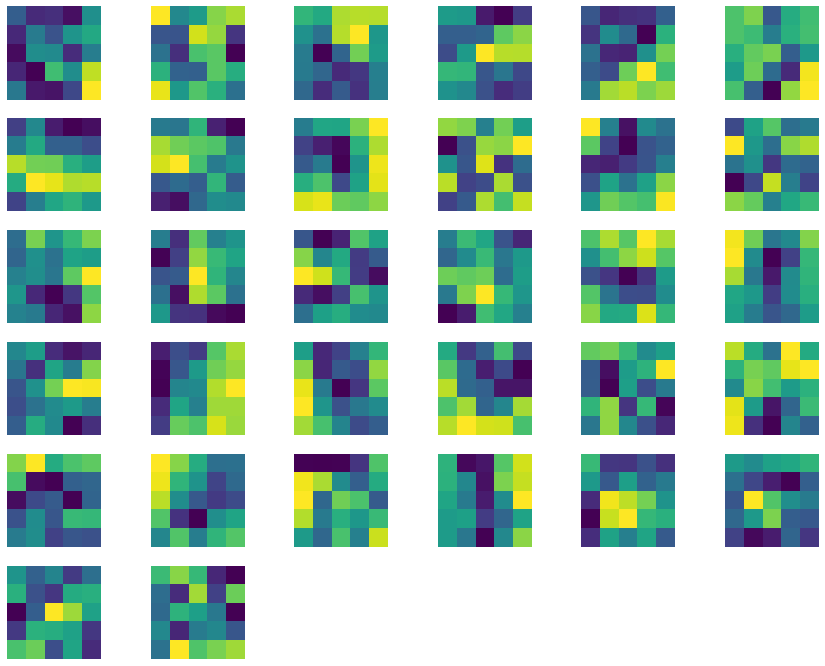

In [69]:
# visualize the first conv layer filters
plt.figure(figsize=(15, 12))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(6, 6, (i % 36) + 1) # (6, 6) because in conv0 we have 5x5 filters and 32 of them
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

#### Second convolutional layer filters

<ipython-input-70-e0533e06d9b0>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(6, 6, (i % 36) + 1) # (6, 6) because in conv0 we have 5x5 filters and 32 of them


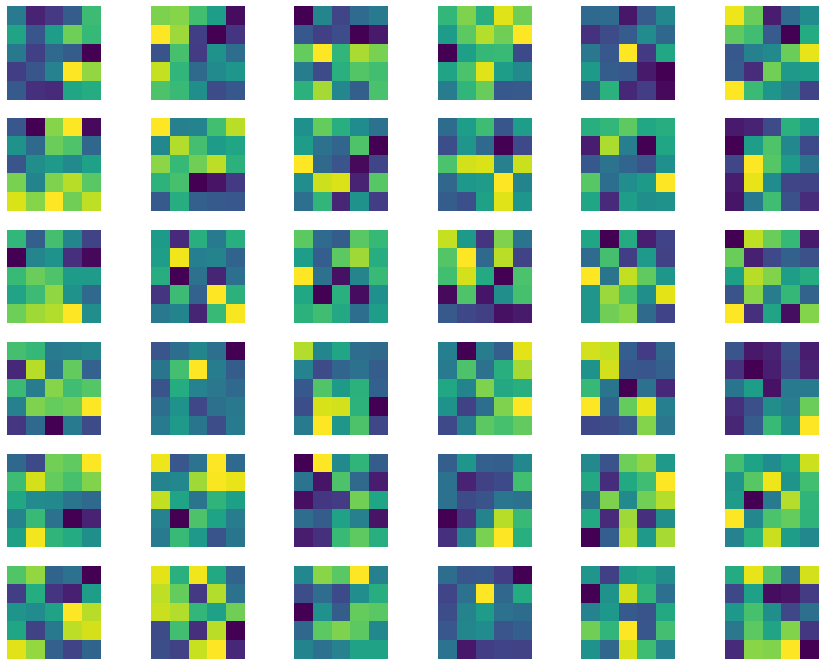

In [70]:
# visualize the second conv layer filters
plt.figure(figsize=(15, 12))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, (i % 36) + 1) # (6, 6) because in conv0 we have 5x5 filters and 32 of them
    plt.imshow(filter[0, :, :].detach())
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()

### Feature map on a face

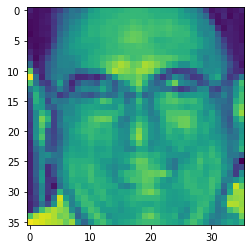

torch.Size([1, 36, 36])
torch.Size([1, 1, 36, 36])


In [71]:
img = Image.open('./start_deep/test_images/1/7_0__t0,0_r0_s1.pgm')
plt.imshow(img)
plt.show()

# apply the transforms
img = transform(img)
print(img.size())

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [72]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([32, 36, 36])
Saving layer 0 feature maps...


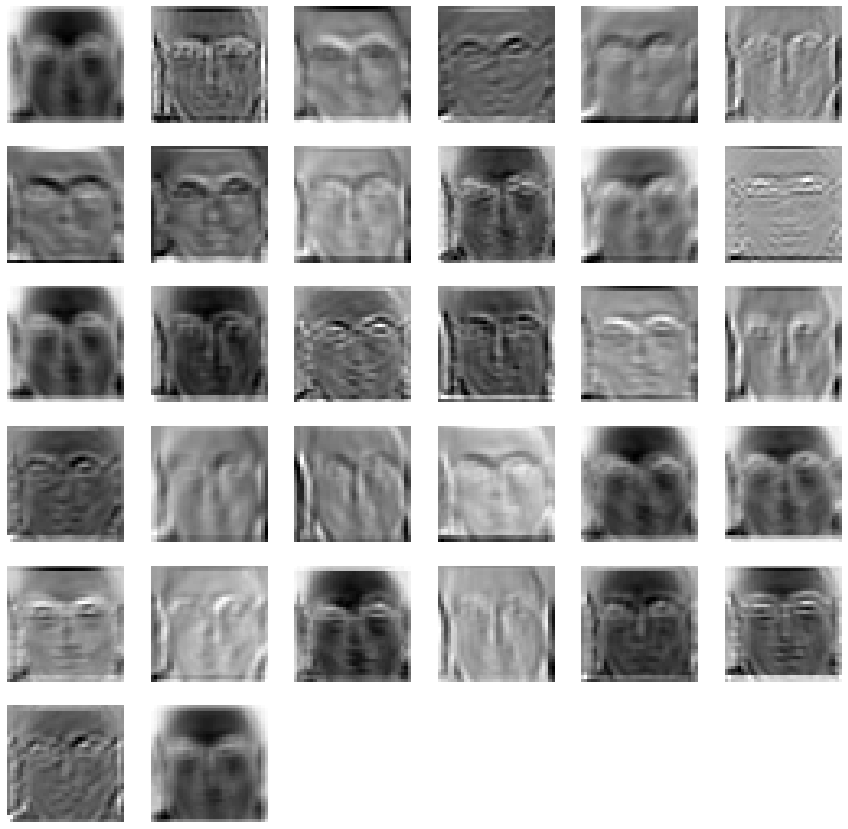

torch.Size([64, 36, 36])
Saving layer 1 feature maps...


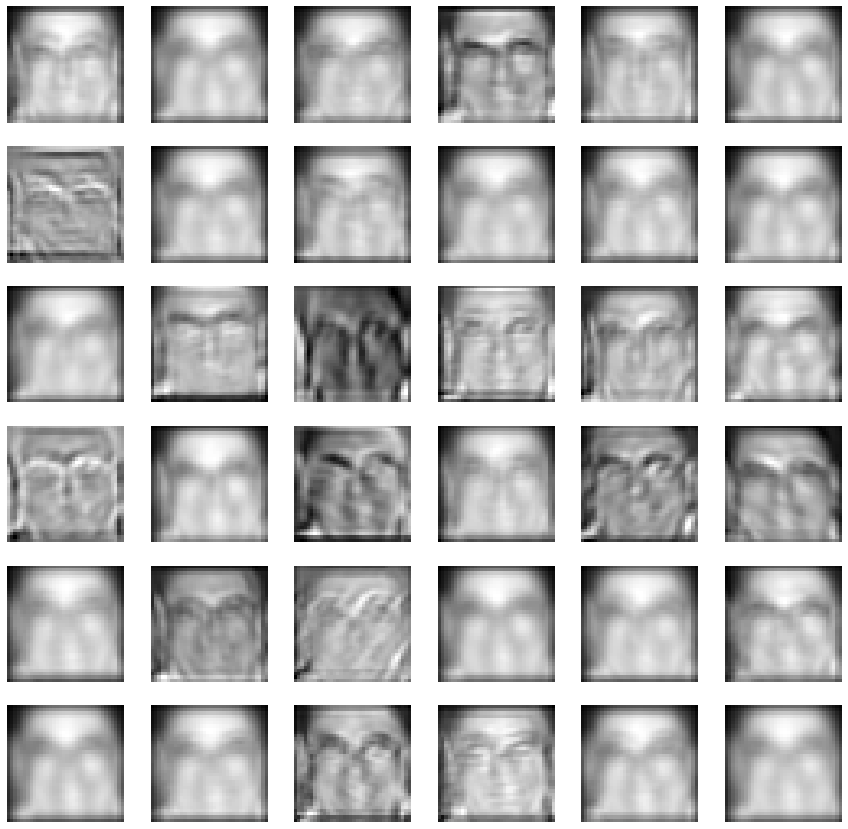

In [74]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(15, 15))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 6x6 blocks from each layer
            break
        plt.subplot(6, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()

### Feature map on a no face

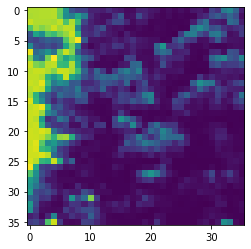

torch.Size([1, 36, 36])
torch.Size([1, 1, 36, 36])


In [75]:
img = Image.open('./start_deep/test_images/0/1280px-2009-0627-SpadenaWitch-house.jpg_1057_353_104_104.pgm')
plt.imshow(img)
plt.show()

# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [76]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

torch.Size([32, 36, 36])
Saving layer 0 feature maps...


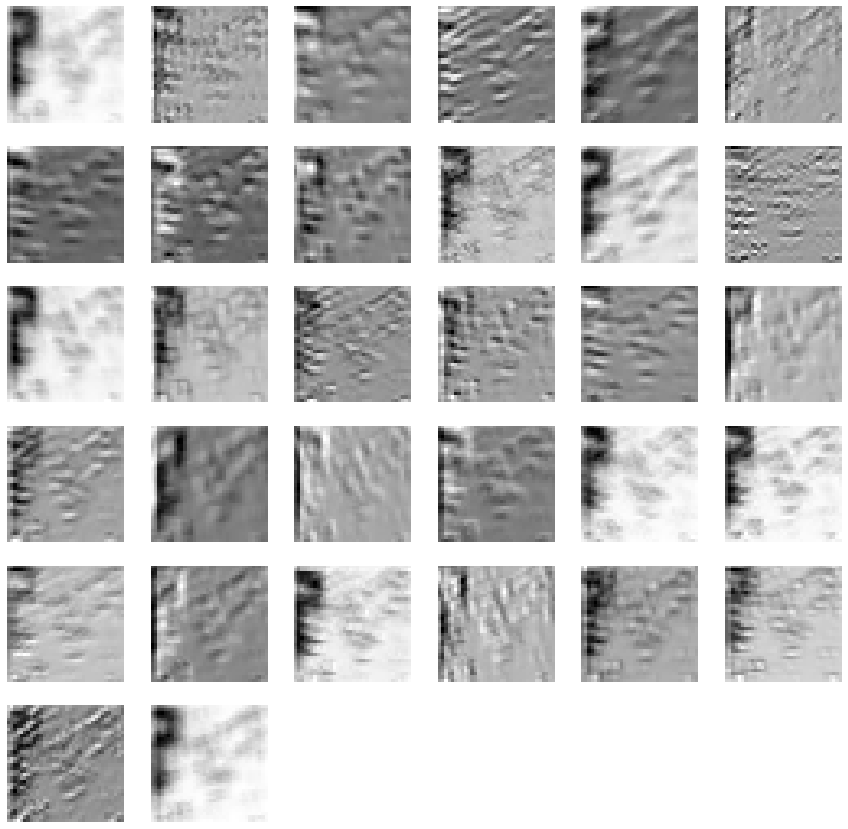

torch.Size([64, 36, 36])
Saving layer 1 feature maps...


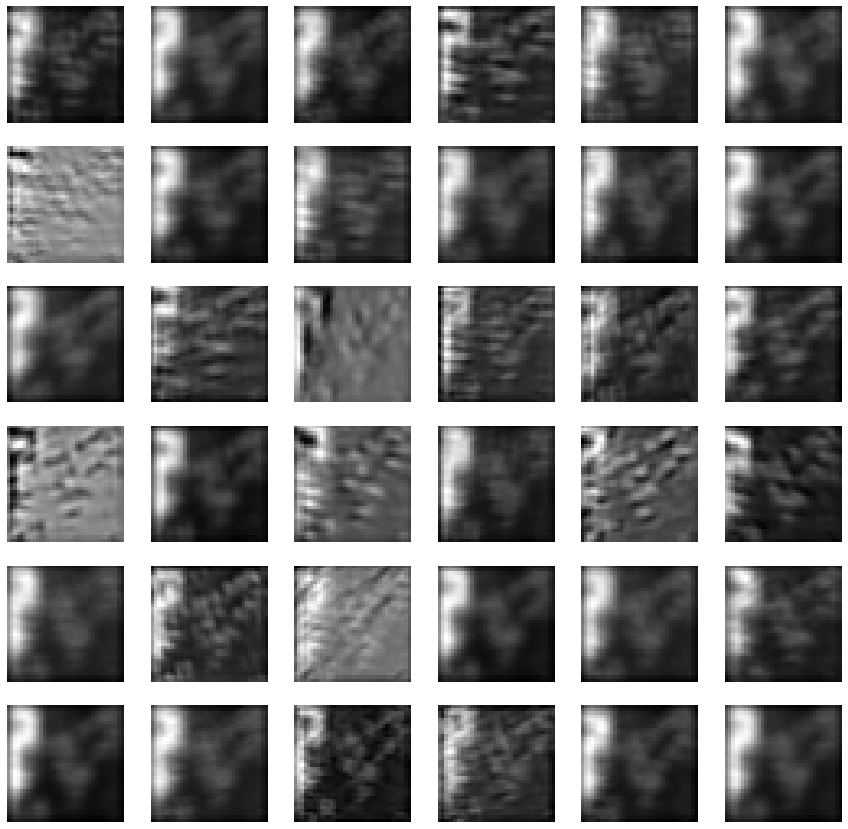

In [77]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(15, 15))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 6x6 blocks from each layer
            break
        plt.subplot(6, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()

### Saving Models

In [78]:
param_file_name = "40epoch"
PATH = "./saved_models/"
torch.save(model.state_dict(), PATH + "weights_" + param_file_name) # save only the parameters of the model
#torch.save(model, PATH +"model_"+ param_file_name)           # save the whole model

### Loading Models

In [10]:
param_file_name = "40epoch"
PATH = "./saved_models/"

# load model parameters file
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvNet().to(device)
model.load_state_dict(torch.load(PATH+"weights_"+param_file_name))

#load conmplet model
#model = torch.load(PATH +"model_"+ param_file_name)

<All keys matched successfully>

# Face Detector

In [38]:
class FaceDetector(object):
    def __init__(self, cnn):
        self.cnn = cnn
    
    # Method to draw box to delimit detected face
    def _draw(self, image, boxes):
        plt.imshow(image[0], cmap=plt.get_cmap("gray"))
        ax = plt.gca()
        for box in boxes:
            x, y, factor = box
            
            x /= factor
            y /= factor
            
            edge = 36 // factor
            rect = mpl.patches.Rectangle((x, y), edge, edge, color='r', fill=False)
            ax.add_patch(rect)
    
    # Entry point, gets an image as input
    def detect(self, image):
        face_pos = list()
        
        n_resize = 4
        factor_increment = 0.1
        threshold = 15 #To be tuned? Unsure
        step = 2
        
        for i in range(n_resize):
            factor = 1 - i * factor_increment

            # round off pixels
            resize_l = int(image.size[0] * factor)
            resize_w = int(image.size[1] * factor)
            resized_image = transform(image.resize((resize_l, resize_w)))
            
            x_range = resized_image.shape[2] - 36
            y_range = resized_image.shape[1] - 36
        
            for x in range(0, x_range, step): 
                for y in range(0, y_range, step):
                    input_img = resized_image[:, y:y+36, x:x+36]
                    plt.imshow(input_img[0], cmap=plt.get_cmap("gray"))
                    input_img = input_img.unsqueeze(0)
                    
                    output = self.cnn(input_img)
                    no_face, face = output.data.tolist()[0]
                    
                    if (face - no_face > threshold):
                        face_pos.append([x, y, factor])
                        
        self._draw(transform(image), face_pos)

### Application

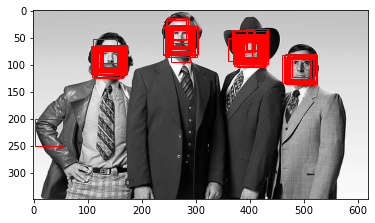

In [39]:
# Image resizes are a workaround, to be removed once factor resizes implemented
image1 = Image.open("./pics_with_faces/faces.jpg")
image2 = Image.open("./pics_with_faces/faces2.jpg")

fd = FaceDetector(model)
fd.detect(image1)
#fd.detect(image2)